In [5]:
import tensorflow as tf
from tensorflow import keras
import math
import numpy as np
import pandas as pd
import matplotlib as mt
import sklearn
import csv
from keras import layers 
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D 
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D 
from keras.models import Model , Sequential
import keras.backend as K
import sklearn
from sklearn.model_selection import train_test_split


KeyboardInterrupt: 

In [ ]:
#Model


def placeholder_inputs(batch_size, num_point):
    pointclouds_pl = tf.placeholder(tf.float32,
                                     shape=(batch_size, num_point, 9))
    labels_pl = tf.placeholder(tf.int32,
                                shape=(batch_size, num_point))
    return pointclouds_pl, labels_pl

def get_model(point_cloud, is_training, bn_decay=None):
    """ ConvNet baseline, input is BxNx3 gray image """
    batch_size = point_cloud.get_shape()[0].value
    num_point = point_cloud.get_shape()[1].value

    input_image = tf.expand_dims(point_cloud, -1)
    # CONV
    net = tf_util.conv2d(input_image, 64, [1,9], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv1', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 64, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv2', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 64, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv3', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 128, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv4', bn_decay=bn_decay)
    points_feat1 = tf_util.conv2d(net, 1024, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv5', bn_decay=bn_decay)
    # MAX
    pc_feat1 = tf_util.max_pool2d(points_feat1, [num_point,1], padding='VALID', scope='maxpool1')
    # FC
    pc_feat1 = tf.reshape(pc_feat1, [batch_size, -1])
    pc_feat1 = tf_util.fully_connected(pc_feat1, 256, bn=True, is_training=is_training, scope='fc1', bn_decay=bn_decay)
    pc_feat1 = tf_util.fully_connected(pc_feat1, 128, bn=True, is_training=is_training, scope='fc2', bn_decay=bn_decay)
    print(pc_feat1)
   
    # CONCAT 
    pc_feat1_expand = tf.tile(tf.reshape(pc_feat1, [batch_size, 1, 1, -1]), [1, num_point, 1, 1])
    points_feat1_concat = tf.concat(axis=3, values=[points_feat1, pc_feat1_expand])
    
    # CONV 
    net = tf_util.conv2d(points_feat1_concat, 512, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv6')
    net = tf_util.conv2d(net, 256, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv7')
    net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training, scope='dp1')
    net = tf_util.conv2d(net, 13, [1,1], padding='VALID', stride=[1,1],
                         activation_fn=None, scope='conv8')
    net = tf.squeeze(net, [2])

    return net

def get_loss(pred, label):
    """ pred: B,N,13
        label: B,N """
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=label)
    return tf.reduce_mean(loss)


    with tf.Graph().as_default():
        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)
            

In [ ]:
#Train
BATCH_SIZE = 24
NUM_POINT = 4096
MAX_EPOCH = 50
NUM_POINT = num_point
BASE_LEARNING_RATE = 0.001
MOMENTUM = 0.9
OPTIMIZER = 'adam'
DECAY_STEP = 300000
DECAY_RATE = 0.5
MAX_NUM_POINT = 4096
NUM_CLASSES = 13

# Load ALL data
data_batch_list = []
label_batch_list = []
for h5_filename in ALL_FILES:
    data_batch, label_batch = provider.loadDataFile(h5_filename)
    data_batch_list.append(data_batch)
    label_batch_list.append(label_batch)
data_batches = np.concatenate(data_batch_list, 0)
label_batches = np.concatenate(label_batch_list, 0)
print(data_batches.shape)
print(label_batches.shape)


train_data = data_batches[train_idxs,...]
train_label = label_batches[train_idxs]
test_data = data_batches[test_idxs,...]
test_label = label_batches[test_idxs]
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)


def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!!
    return learning_rate        




pointclouds_pl, labels_pl = placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            
pred = get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = get_loss(pred, labels_pl)
            tf.summary.scalar('loss', loss)
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE*NUM_POINT)
            tf.summary.scalar('accuracy', accuracy)
# Init variables
        init = tf.global_variables_initializer()
        sess.run(init, {is_training_pl:True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}

In [ ]:
#Evaluate

pred_data_label_filenames = [line.rstrip() for line in open('all_pred_data_label_filelist.txt')]
gt_label_filenames = [f.rstrip('_pred\.txt') + '_gt.txt' for f in pred_data_label_filenames]
num_room = len(gt_label_filenames)


gt_classes = [0 for _ in range(13)]
positive_classes = [0 for _ in range(13)]
true_positive_classes = [0 for _ in range(13)]
for i in range(num_room):
    print(i)
    data_label = np.loadtxt(pred_data_label_filenames[i])
    pred_label = data_label[:,-1]
    gt_label = np.loadtxt(gt_label_filenames[i])
    print(gt_label.shape)
    for j in xrange(gt_label.shape[0]):
        gt_l = int(gt_label[j])
        pred_l = int(pred_label[j])
        gt_classes[gt_l] += 1
        positive_classes[pred_l] += 1
        true_positive_classes[gt_l] += int(gt_l==pred_l)


print(gt_classes)
print(positive_classes)
print(true_positive_classes)


print('Overall accuracy: {0}'.format(sum(true_positive_classes)/float(sum(positive_classes))))

print 'IoU:'
iou_list = []
for i in range(13):
    iou = true_positive_classes[i]/float(gt_classes[i]+positive_classes[i]-true_positive_classes[i]) 
    print(iou)
    iou_list.append(iou)

print(sum(iou_list)/13.0)


In [ ]:
#trail
X_train.reshape() and X_test.reshape()
to_categorical() 
model.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))

In [ ]:
#Final outlook
ds = pd.read_csv('dataset.csv')

mydata=np.genfromtxt('dataset.csv',delimiter=',')
x=mydata[:,0:4001]
y=mydata[:,4001]


Y = np.zeros((50,10))
for i in range(50):
    for k in range(9):
        if y[i]==k:
            Y[i,k]=1
        
X=np.zeros((50,4001,1))
X[:,:,0]=x


X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=1)

#model
model = Sequential()
n_i = 4001
no_kernels = 1
length_of_kernel = 2001

model.add(Conv1D(no_kernels,length_of_kernel,activation='relu',padding='same',strides=16,input_shape=(n_i,1)))
model.add(MaxPooling1D(3,strides=2,name='max_pool1'))

model.add(Conv1D(1,5,activation='relu',padding='same',strides=4,input_shape=(125,1)))
model.add(MaxPooling1D(3,strides=2,name='max_pool2'))

model.add(Conv1D(1,5,activation='relu',padding='same',strides=2,input_shape=(15,1)))
model.add(MaxPooling1D(2,strides=1,name='max_pool3'))

model.add(Flatten())

model.add(Dense(10,activation='relu'))

model.add(Dense(10,activation='softmax'))

model.compile(loss='mse',optimizer='adam',metrics =['accuracy'] )



model.fit(X_train,Y_train,batch_size=1,epochs=100,verbose=1)
model.evaluate(X_test,Y_test,verbose =0)




In [1]:
import h5py
f = h5py.File('C:\\Users\\Srividya\\Documents\\GitHub\\pointnet\\sem_seg\\indoor3d_sem_seg_hdf5_data\\ply_data_all_22.h5', 'r')
list(f.keys())

['data', 'label']

In [2]:
dset = f['label']
dset

<HDF5 dataset "label": shape (1000, 4096), type "|u1">

In [3]:
kset = f['data']
kset

<HDF5 dataset "data": shape (1000, 4096, 9), type "<f4">

In [9]:
import numpy as np
np.dtype(dset)
dset[584,4095]

2

In [5]:
kset[1,1,:]

array([-0.114     , -0.262     ,  0.025     ,  0.31764707,  0.3137255 ,
        0.23529412,  0.7646443 ,  0.58146536,  0.00864753], dtype=float32)

<IPython.core.display.Javascript object>


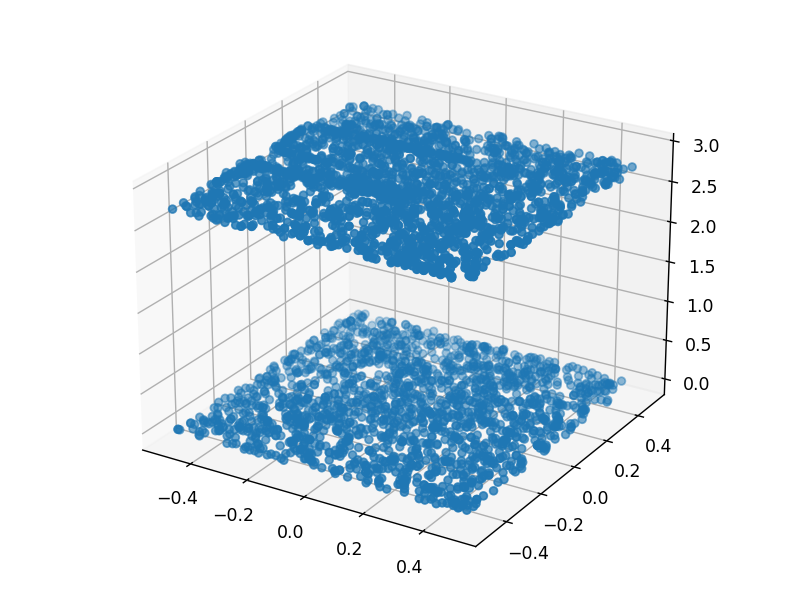

In [5]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(kset[50,:,0] , kset[50,:,1] , kset[50,:,2])

In [9]:
from open3d import *
import numpy as np

#give path to ".npy" file
#pc = np.load('/home/qbot/pointnet/data/stanford_indoor3d/Area_1_conferenceRoom_1.npy') 

pcd = PointCloud()
pcd.points = Vector3dVector(kset[:,0:3]) # XYZ points
pcd.colors = Vector3dVector(kset[:,3:6]/ 255.0)  #open3d requires colors (RGB) to be in range[0,1]
draw_geometries([pcd])

FileNotFoundError: [Errno 2] No such file or directory: '/home/qbot/pointnet/data/stanford_indoor3d/Area_1_conferenceRoom_1.npy'

In [14]:
print("Load a ply point cloud, print it, and render it")
    #pcd = o3d.io.read_point_cloud("../../TestData/fragment.ply")
    #print(pcd)
#print(np.asarray(f.data))
open3d.visualization.draw_geometries([f])

Load a ply point cloud, print it, and render it


TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False) -> None
    2. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False, lookat: numpy.ndarray[float64[3, 1]], up: numpy.ndarray[float64[3, 1]], front: numpy.ndarray[float64[3, 1]], zoom: float) -> None

Invoked with: [<HDF5 file "ply_data_all_22.h5" (mode r)>]

In [6]:
import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

In [3]:
ALL_FILES = [line.rstrip() for line in open('indoor3d_sem_seg_hdf5_data/all_files.txt')]#provider.getDataFiles('indoor3d_sem_seg_hdf5_data/all_files.txt')
# Load ALL data
data_batch_list = []
label_batch_list = []
for h5_filename in ALL_FILES:
    data_batch, label_batch = load_h5(h5_filename)
    data_batch_list.append(data_batch)
    label_batch_list.append(label_batch)
data_batches = np.concatenate(data_batch_list, 0)
label_batches = np.concatenate(label_batch_list, 0)
print(data_batches.shape)
print(label_batches.shape)


<ipython-input-2-770c02b77a2f>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


(23585, 4096, 9)
(23585, 4096)


In [4]:
# x = data_batches[:,0:4001]
# y = label_batches[:,:]

cat_labels = tf.keras.utils.to_categorical(label_batches, num_classes = 13, dtype = "uint8")
cat_labels[0:2,0:4]
# Y = np.zeros((50,10))
# for i in range(50):
#     for k in range(9):
#         if y[i]==k:
#             Y[i,k]=1
        
# X=np.zeros((50,4001,1))
# X[:,:,0]=x


#X_train, X_test, Y_train, Y_test = train_test_split( data_batches, label_batches_cat , test_size=0.2, random_state=1)


array([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [ ]:
# X_train = data_batches[0:10000,:,:]
# X_test =  data_batches[11000:12000,:,:]
# Y_train = cat_labels[0:10000,:,:]
# Y_test =  cat_labels[11000:12000,:,:]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split( data_batches, cat_labels , test_size=0.2, random_state=1)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18868, 4096, 9)
(4717, 4096, 9)
(18868, 4096, 13)
(4717, 4096, 13)


In [8]:
np.shape(cat_labels)[1]

4096

<ipython-input-5-9cc29108f2bc>:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


(100, 4096, 9)
(100, 4096)
(80, 4096, 9)
(20, 4096, 9)
(80, 4096)
(20, 4096)
(None, 4096, 1, 64)
(None, 4096, 1, 1024)
(None, 1, 1, 1024)
(None, 1024)
(None, 128)
(None, 1, 1, 128)
(None, 4096, 1, 128)
(None, 4096, 1, 1152)
Epoch 1/10
4/4 [==============================] - 12s 3s/step - loss: 2.4723 - accuracy: 0.2167
Epoch 2/10
4/4 [==============================] - 15s 4s/step - loss: 1.7659 - accuracy: 0.2971
Epoch 3/10
4/4 [==============================] - 14s 3s/step - loss: 1.4043 - accuracy: 0.5048
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 1.0395 - accuracy: 0.6361
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 0.8438 - accuracy: 0.6511
Epoch 6/10
4/4 [==============================] - 15s 4s/step - loss: 0.6905 - accuracy: 0.7374
Epoch 7/10
4/4 [==============================] - 15s 4s/step - loss: 0.5918 - accuracy: 0.7951
Epoch 8/10
4/4 [==============================] - 14s 3s/step - loss: 0.5276 - accuracy: 0.8187
Epoch 9/

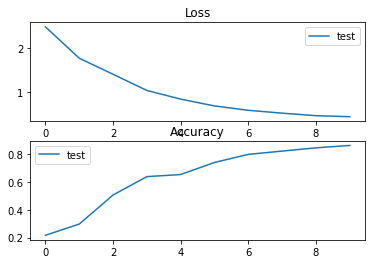

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

# SOME_FILES = [line.rstrip() for line in open('indoor3d_sem_seg_hdf5_data/someFiles.txt')]#provider.getDataFiles('indoor3d_sem_seg_hdf5_data/all_files.txt')
# # Load ALL data
# data_batch_list = []
# label_batch_list = []
# for h5_filename in SOME_FILES:
#     data_batch, label_batch = load_h5(h5_filename)
#     data_batch_list.append(data_batch)
#     label_batch_list.append(label_batch)
# data_batches = np.concatenate(data_batch_list, 0)
# label_batches = np.concatenate(label_batch_list, 0)

data_batch, label_batch = load_h5('indoor3d_sem_seg_hdf5_data/ply_data_all_5.h5')
data_batches = data_batch[0:100,:,:]
label_batches = label_batch[0:100,:]
print(data_batches.shape)
print(label_batches.shape)
#cat_labels = tf.keras.utils.to_categorical(label_batches, num_classes = 13, dtype = "uint8")
X_train, X_test, Y_train, Y_test = train_test_split( data_batches, label_batches , test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

input_image = keras.Input(shape = (4096,9,1))                                                            #B*N*9*1
num_point = 4096
x = Conv2D(64, [1,9], padding='VALID', strides = [1,1], activation = 'relu', name ='conv1')(input_image) #B*N*1*64
print(x.shape)
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv2')(x)           #B*N*1*64
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv3')(x)           #B*N*1*64
x = Conv2D(128, [1,1], padding='VALID', strides = [1,1],activation = 'relu', name ='conv4')(x)           #B*N*1*128
x= Conv2D(1024, [1,1], padding='VALID', strides = [1,1], activation = 'relu',name ='conv5')(x)           #B*N*1*1024
                                                                    #Now x is partial feature vector of each point
    # max pooling as a symmetric function is a key point to solve the cloud of disorder.
print(x.shape)
pc_feat1 = MaxPooling2D([num_point,1],strides=(2, 2), padding='VALID', name ='maxpool1')(x)   #maxpooling for each channel 
print(pc_feat1.shape)
pc_feat1 = Flatten()(pc_feat1)
print(pc_feat1.shape)
#model.add(Flatten())
pc_feat1 = Dense(256, activation = 'relu', name='fc1')(pc_feat1)        #global feature vectors through fully connected layers                                                      
pc_feat1 = Dense(128 , activation = 'relu', name='fc2')(pc_feat1)
print(pc_feat1.shape)
# CONCAT
a = tf.keras.layers.Reshape((1, 1, -1))(pc_feat1)                   #B*1*1*128
print(a.shape)

pc_feat1_expand = tf.tile(a, [1, num_point, 1, 1])                  #B*N*1*128
print(pc_feat1_expand.shape)
points_feat1_concat = tf.concat(axis=3, values=[x, pc_feat1_expand])#B*N*1*1152    (1024+128)axis = 3 implies along 4th column
print(points_feat1_concat.shape)
# CONV

y = Conv2D(512, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv6')(points_feat1_concat)
y = Conv2D(256, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv7')(y)
# tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)

y = Dropout(rate=0.3)(y)                                                #rate = Fraction of the input units to drop.
y = Conv2D(13, [1, 1], padding='VALID', strides=[1, 1], activation = 'softmax', name='conv8')(y)#B*N*1*13
net = tf.squeeze(y, [2])                                                #B*N*13

# return net
model = keras.Model(inputs=input_image, outputs=net)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["sparse_categorical_accuracy"])
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

history = model.fit(X_train, Y_train, batch_size=24, epochs=10, verbose=1)     #verbose=0 will show you nothing (silent)
model.evaluate(X_test, Y_test, verbose=2)    #verbose=1 will show you an animated progress bar & verbose=2 will just mention the number of epoch

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
                                                    #pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['loss'], label='test')
pyplot.legend()

# plot accuracy during training
 pyplot.subplot(212)
 pyplot.title('Accuracy')
                                                     #pyplot.plot(history.history['accuracy'], label='train')
 pyplot.plot(history.history['accuracy'], label='test')
 pyplot.legend()
 pyplot.show()

# Visualization

(80, 4096, 6)
(80, 4096)
(327680, 6)


<ipython-input-4-c67ab8dfa5c9>:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


<IPython.core.display.Javascript object>


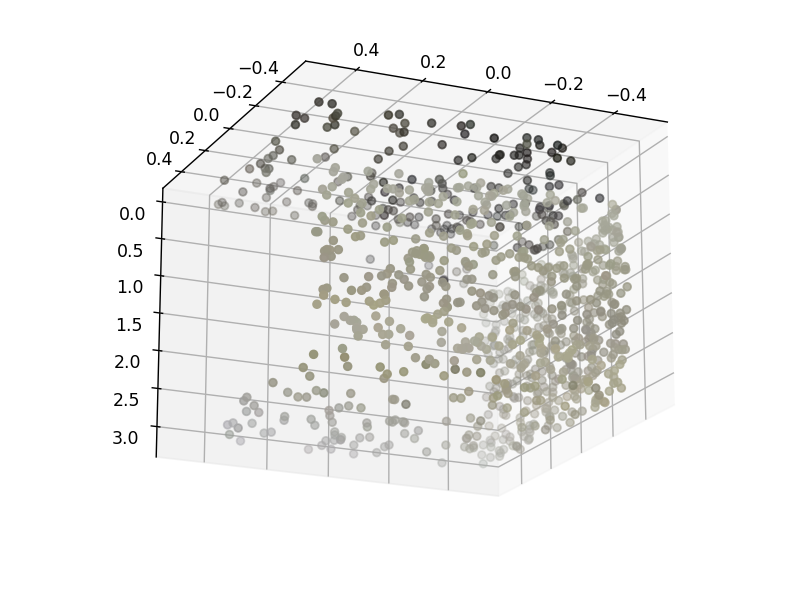

In [4]:
import numpy as np
import open3d
from matplotlib import pyplot as plt
import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


h5_filename = 'indoor3d_sem_seg_hdf5_data/ply_data_all_0.h5'
data_batch, label_batch = load_h5(h5_filename)
dps = data_batch[0:80,:,0:6]
lbs = label_batch[0:80,:]
print(dps.shape)
print(lbs.shape)

#all points in one place for visualisation purpose 
new = dps.reshape((dps.shape[0]*dps.shape[1]),dps.shape[2])
print(new.shape)
# new = dps[0,:,:]
# for i in range(1,3):
#     np.concatenate((new, dps[i,:,:]), axis=1)
# print(new.shape)
# for i in range(4):
#open3d.visualization.draw_geometries([newarr])


%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#scatter = ax.scatter(kset[50,:,0] , kset[50,:,1] , kset[50,:,2])
#for i in range(80):
scatter = ax.scatter(new[0:1000, 0], new[0:1000, 1], new[0:1000, 2], c= new[0:1000,3:6])
#scatter = ax.scatter(new[0:1000, 0], new[0:1000, 1], new[0:1000, 2], c= 'coral')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


# %matplotlib notebook
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import proj3d
# import numpy as np

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# x = new[:, 0]
# y = new[:, 1]
# z = new[:, 2]

# ax.scatter(x, y, z)
# plt.show()
    
    
    
# %matplotlib notebook
# fig = plt.figure(figsize=(15, 10))
# for i in range(80):
#     ax = fig.add_subplot(2, 4, 1, projection="3d")
#     ax.scatter(dps[i, :, 0], dps[i, :, 1], dps[i, :, 2])
#     ax.set_title("Area_1_conferenceRoom_1")
#     ax.set_axis_off()
# plt.show()


#give path to ".npy" file
# pc = np.load('/home/qbot/pointnet/data/stanford_indoor3d/Area_1_conferenceRoom_1.npy') 

# pcd = open3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(pc[:,0:3]) # XYZ points
# pcd.colors = open3d.utility.Vector3dVector(pc[:,3:6]/ 255.0)  #open3d requires colors (RGB) to be in range[0,1]
# open3d.visualization.draw_geometries([pcd])

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [34]:
a = np.array([[1, 2], [3, 4]])

b = np.array([[5, 6]])

np.concatenate((a, b), axis=0)


array([[1, 2],
       [3, 4],
       [5, 6]])

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

# SOME_FILES = [line.rstrip() for line in open('indoor3d_sem_seg_hdf5_data/someFiles.txt')]#provider.getDataFiles('indoor3d_sem_seg_hdf5_data/all_files.txt')
# # Load ALL data
# data_batch_list = []
# label_batch_list = []
# for h5_filename in SOME_FILES:
#     data_batch, label_batch = load_h5(h5_filename)
#     data_batch_list.append(data_batch)
#     label_batch_list.append(label_batch)
# data_batches = np.concatenate(data_batch_list, 0)
# label_batches = np.concatenate(label_batch_list, 0)

data_batch, label_batch = load_h5('indoor3d_sem_seg_hdf5_data/ply_data_all_5.h5')
data_batches = data_batch[0:100,:,:]
label_batches = label_batch[0:100,:]
print(data_batches.shape)
print(label_batches.shape)
#cat_labels = tf.keras.utils.to_categorical(label_batches, num_classes = 13, dtype = "uint8")
X_train, X_test, Y_train, Y_test = train_test_split( data_batches, label_batches , test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

input_image = keras.Input(shape = (4096,9,1))                                                            #B*N*9*1
num_point = 4096
x = Conv2D(64, [1,9], padding='VALID', strides = [1,1], activation = 'relu', name ='conv1')(input_image) #B*N*1*64
print(x.shape)
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv2')(x)           #B*N*1*64
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv3')(x)           #B*N*1*64
x = Conv2D(128, [1,1], padding='VALID', strides = [1,1],activation = 'relu', name ='conv4')(x)           #B*N*1*128
x= Conv2D(1024, [1,1], padding='VALID', strides = [1,1], activation = 'relu',name ='conv5')(x)           #B*N*1*1024
                                                                    #Now x is partial feature vector of each point
    # max pooling as a symmetric function is a key point to solve the cloud of disorder.
print(x.shape)
pc_feat1 = MaxPooling2D([num_point,1],strides=(2, 2), padding='VALID', name ='maxpool1')(x)   #maxpooling for each channel 
print(pc_feat1.shape)
pc_feat1 = Flatten()(pc_feat1)
print(pc_feat1.shape)
#model.add(Flatten())
pc_feat1 = Dense(256, activation = 'relu', name='fc1')(pc_feat1)        #global feature vectors through fully connected layers                                                      
pc_feat1 = Dense(128 , activation = 'relu', name='fc2')(pc_feat1)
print(pc_feat1.shape)
# CONCAT
a = tf.keras.layers.Reshape((1, 1, -1))(pc_feat1)                   #B*1*1*128
print(a.shape)

pc_feat1_expand = tf.tile(a, [1, num_point, 1, 1])                  #B*N*1*128
print(pc_feat1_expand.shape)
points_feat1_concat = tf.concat(axis=3, values=[x, pc_feat1_expand])#B*N*1*1152    (1024+128)axis = 3 implies along 4th column
print(points_feat1_concat.shape)
# CONV

y = Conv2D(512, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv6')(points_feat1_concat)
y = Conv2D(256, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv7')(y)
# tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)

y = Dropout(rate=0.3)(y)                                                #rate = Fraction of the input units to drop.
y = Conv2D(13, [1, 1], padding='VALID', strides=[1, 1], activation = 'softmax', name='conv8')(y)#B*N*1*13
net = tf.squeeze(y, [2])                                                #B*N*13

# return net
model = keras.Model(inputs=input_image, outputs=net)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model.fit(X_train, Y_train, batch_size=24, epochs=1, verbose=1)     #verbose=0 will show you nothing (silent)
model.evaluate(X_test, Y_test, verbose=2)    #verbose=1 will show you an animated progress bar & verbose=2 will just mention the number of epoch



<ipython-input-7-246f1be69edc>:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


(100, 4096, 9)
(100, 4096)
(80, 4096, 9)
(20, 4096, 9)
(80, 4096)
(20, 4096)
(None, 4096, 1, 64)
(None, 4096, 1, 1024)
(None, 1, 1, 1024)
(None, 1024)
(None, 128)
(None, 1, 1, 128)
(None, 4096, 1, 128)
(None, 4096, 1, 1152)
4/4 [==============================] - 12s 3s/step - loss: 2.4769 - accuracy: 0.4329
1/1 - 0s - loss: 2.0001 - accuracy: 0.6153


[2.0001139640808105, 0.615344226360321]

In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

# SOME_FILES = [line.rstrip() for line in open('indoor3d_sem_seg_hdf5_data/someFiles.txt')]#provider.getDataFiles('indoor3d_sem_seg_hdf5_data/all_files.txt')
# # Load ALL data
# data_batch_list = []
# label_batch_list = []
# for h5_filename in SOME_FILES:
#     data_batch, label_batch = load_h5(h5_filename)
#     data_batch_list.append(data_batch)
#     label_batch_list.append(label_batch)
# data_batches = np.concatenate(data_batch_list, 0)
# label_batches = np.concatenate(label_batch_list, 0)

data_batch, label_batch = load_h5('indoor3d_sem_seg_hdf5_data/ply_data_all_5.h5')
data_batches = data_batch[0:100,:,:]
label_batches = label_batch[0:100,:]
print(data_batches.shape)
print(label_batches.shape)
#cat_labels = tf.keras.utils.to_categorical(label_batches, num_classes = 13, dtype = "uint8")
X_train, X_test, Y_train, Y_test = train_test_split( data_batches, label_batches , test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

input_image = keras.Input(shape = (4096,9,1))                                                            #B*N*9*1
num_point = 4096
x = Conv2D(64, [1,9], padding='VALID', strides = [1,1], activation = 'relu', name ='conv1')(input_image) #B*N*1*64
print(x.shape)
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv2')(x)           #B*N*1*64
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv3')(x)           #B*N*1*64
x = Conv2D(128, [1,1], padding='VALID', strides = [1,1],activation = 'relu', name ='conv4')(x)           #B*N*1*128
x= Conv2D(1024, [1,1], padding='VALID', strides = [1,1], activation = 'relu',name ='conv5')(x)           #B*N*1*1024
                                                                    #Now x is partial feature vector of each point
    # max pooling as a symmetric function is a key point to solve the cloud of disorder.
print(x.shape)
pc_feat1 = MaxPooling2D([num_point,1],strides=(2, 2), padding='VALID', name ='maxpool1')(x)   #maxpooling for each channel 
print(pc_feat1.shape)
pc_feat1 = Flatten()(pc_feat1)
print(pc_feat1.shape)
#model.add(Flatten())
pc_feat1 = Dense(256, activation = 'relu', name='fc1')(pc_feat1)        #global feature vectors through fully connected layers                                                      
pc_feat1 = Dense(128 , activation = 'relu', name='fc2')(pc_feat1)
print(pc_feat1.shape)
# CONCAT
a = tf.keras.layers.Reshape((1, 1, -1))(pc_feat1)                   #B*1*1*128
print(a.shape)

pc_feat1_expand = tf.tile(a, [1, num_point, 1, 1])                  #B*N*1*128
print(pc_feat1_expand.shape)
points_feat1_concat = tf.concat(axis=3, values=[x, pc_feat1_expand])#B*N*1*1152    (1024+128)axis = 3 implies along 4th column
print(points_feat1_concat.shape)
# CONV

y = Conv2D(512, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv6')(points_feat1_concat)
y = Conv2D(256, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv7')(y)
# tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)

y = Dropout(rate=0.3)(y)                                                #rate = Fraction of the input units to drop.
y = Conv2D(13, [1, 1], padding='VALID', strides=[1, 1], activation = 'softmax', name='conv8')(y)#B*N*1*13
net = tf.squeeze(y, [2])                                                #B*N*13

# return net
model = keras.Model(inputs=input_image, outputs=net)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["sparse_categorical_accuracy"])
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

history = model.fit(X_train, Y_train, batch_size=24, epochs=10, verbose=1)     #verbose=0 will show you nothing (silent)
model.evaluate(X_test, Y_test, verbose=2)    #verbose=1 will show you an animated progress bar & verbose=2 will just mention the number of epoch

# plot loss during training
# pyplot.subplot(211)
# pyplot.title('Loss')
#                                                     #pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['loss'], label='test')
# pyplot.legend()

# plot accuracy during training
# pyplot.subplot(212)
# pyplot.title('Accuracy')
#                                                     #pyplot.plot(history.history['accuracy'], label='train')
# pyplot.plot(history.history['accuracy'], label='test')
# pyplot.legend()
# pyplot.show()

<ipython-input-16-dffc617b9deb>:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


(100, 4096, 9)
(100, 4096)
(80, 4096, 9)
(20, 4096, 9)
(80, 4096)
(20, 4096)
(None, 4096, 1, 64)
(None, 4096, 1, 1024)
(None, 1, 1, 1024)
(None, 1024)
(None, 128)
(None, 1, 1, 128)
(None, 4096, 1, 128)
(None, 4096, 1, 1152)
Epoch 1/10
4/4 [==============================] - 12s 3s/step - loss: 2.4787 - sparse_categorical_accuracy: 0.2503
Epoch 2/10
4/4 [==============================] - 12s 3s/step - loss: 1.8393 - sparse_categorical_accuracy: 0.3457
Epoch 3/10
4/4 [==============================] - 14s 4s/step - loss: 1.4055 - sparse_categorical_accuracy: 0.5775
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 1.0143 - sparse_categorical_accuracy: 0.6333
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 0.8127 - sparse_categorical_accuracy: 0.6636
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.7242 - sparse_categorical_accuracy: 0.7204
Epoch 7/10
4/4 [==============================] - 13s 3s/step - loss: 0.5669 - sparse_

[0.2302008867263794, 0.9023193120956421]

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'array'

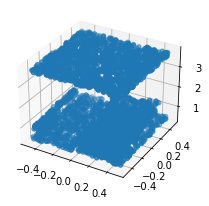

In [33]:
preds = model.predict(X_test)
preds = tf.math.argmax(preds, -1)

#X_test = X_test.numpy()

# plot points with predicted class and label
fig = pyplot.figure(figsize=(15, 10))
for i in range(1):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(X_test[i, :, 0], X_test[i, :, 1], X_test[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            [preds.[i]], [Y_test.[i]]
        )
    )
    ax.set_axis_off()
pyplot.show()

In [ ]:

pred_data_label_filenames = [line.rstrip() for line in open('all_pred_data_label_filelist.txt')]
gt_label_filenames = [f.rstrip('_pred\.txt') + '_gt.txt' for f in pred_data_label_filenames]
num_room = len(gt_label_filenames)


gt_classes = [0 for _ in range(13)]
positive_classes = [0 for _ in range(13)]
true_positive_classes = [0 for _ in range(13)]
for i in range(num_room):
    print(i)
    data_label = np.loadtxt(pred_data_label_filenames[i])
    pred_label = data_label[:,-1]
    gt_label = np.loadtxt(gt_label_filenames[i])
    print(gt_label.shape)
    for j in xrange(gt_label.shape[0]):
        gt_l = int(gt_label[j])
        pred_l = int(pred_label[j])
        gt_classes[gt_l] += 1
        positive_classes[pred_l] += 1
        true_positive_classes[gt_l] += int(gt_l==pred_l)


print(gt_classes)
print(positive_classes)
print(true_positive_classes)


print('Overall accuracy: {0}'.format(sum(true_positive_classes)/float(sum(positive_classes))))

print 'IoU:'
iou_list = []
for i in range(13):
    iou = true_positive_classes[i]/float(gt_classes[i]+positive_classes[i]-true_positive_classes[i]) 
    print(iou)
    iou_list.append(iou)

print(sum(iou_list)/13.0)


# My code

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split

import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

# SOME_FILES = [line.rstrip() for line in open('indoor3d_sem_seg_hdf5_data/someFiles.txt')]#provider.getDataFiles('indoor3d_sem_seg_hdf5_data/all_files.txt')
# # Load ALL data
# data_batch_list = []
# label_batch_list = []
# for h5_filename in SOME_FILES:
#     data_batch, label_batch = load_h5(h5_filename)
#     data_batch_list.append(data_batch)
#     label_batch_list.append(label_batch)
# data_batches = np.concatenate(data_batch_list, 0)
# label_batches = np.concatenate(label_batch_list, 0)

data_batch, label_batch = load_h5('indoor3d_sem_seg_hdf5_data/ply_data_all_5.h5')
data_batches = data_batch[0:100,:,:]
label_batches = label_batch[0:100,:]
print(data_batches.shape)
print(label_batches.shape)

cat_labels = tf.keras.utils.to_categorical(label_batches, num_classes = 13, dtype = "uint8")
X_train, X_test, Y_train, Y_test = train_test_split( data_batches, cat_labels , test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

input_image = keras.Input(shape = (4096,9,1))                                                            #B*N*9*1
num_point = 4096
x = Conv2D(64, [1,9], padding='VALID', strides = [1,1], activation = 'relu', name ='conv1')(input_image) #B*N*1*64
print(x.shape)
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv2')(x)           #B*N*1*64
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], activation = 'relu', name ='conv3')(x)           #B*N*1*64
x = Conv2D(128, [1,1], padding='VALID', strides = [1,1],activation = 'relu', name ='conv4')(x)           #B*N*1*128
x= Conv2D(1024, [1,1], padding='VALID', strides = [1,1], activation = 'relu',name ='conv5')(x)           #B*N*1*1024
                                                                    #Now x is partial feature vector of each point
    # max pooling as a symmetric function is a key point to solve the cloud of disorder.
print(x.shape)
pc_feat1 = MaxPooling2D([num_point,1],strides=(2, 2), padding='VALID', name ='maxpool1')(x)   #maxpooling for each channel 
print(pc_feat1.shape)
pc_feat1 = Flatten()(pc_feat1)
print(pc_feat1.shape)
#model.add(Flatten())
pc_feat1 = Dense(256, activation = 'relu', name='fc1')(pc_feat1)        #global feature vectors through fully connected layers                                                      
pc_feat1 = Dense(128 , activation = 'relu', name='fc2')(pc_feat1)
print(pc_feat1.shape)
# CONCAT
a = tf.keras.layers.Reshape((1, 1, -1))(pc_feat1)                   #B*1*1*128
print(a.shape)

pc_feat1_expand = tf.tile(a, [1, num_point, 1, 1])                  #B*N*1*128
print(pc_feat1_expand.shape)
points_feat1_concat = tf.concat(axis=3, values=[x, pc_feat1_expand])#B*N*1*1152    (1024+128)axis = 3 implies along 4th column
print(points_feat1_concat.shape)
# CONV

y = Conv2D(512, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv6')(points_feat1_concat)
y = Conv2D(256, [1, 1], padding='VALID', strides=[1, 1], activation = 'relu', name='conv7')(y)
# tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)

y = Dropout(rate=0.3)(y)                                                #rate = Fraction of the input units to drop.
y = Conv2D(13, [1, 1], padding='VALID', strides=[1, 1], activation = 'softmax', name='conv8')(y)#B*N*1*13
net = tf.squeeze(y, [2])                                                                        #B*N*13

# return net
model = keras.Model(inputs=input_image, outputs=net)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model.fit(X_train, Y_train, batch_size=24, epochs=3, verbose=1)     #verbose=0 will show you nothing (silent)
model.evaluate(X_test, Y_test, verbose=2)    #verbose=1 will show you an animated progress bar & verbose=2 will just mention the number of epoch


<ipython-input-8-be50aece1625>:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


(100, 4096, 9)
(100, 4096)
(80, 4096, 9)
(20, 4096, 9)
(80, 4096, 13)
(20, 4096, 13)
(None, 4096, 1, 64)
(None, 4096, 1, 1024)
(None, 1, 1, 1024)
(None, 1024)
(None, 128)
(None, 1, 1, 128)
(None, 4096, 1, 128)
(None, 4096, 1, 1152)
Epoch 1/3
4/4 [==============================] - 14s 3s/step - loss: 4.1741 - accuracy: 0.2274
Epoch 2/3
4/4 [==============================] - 33s 8s/step - loss: 15.3471 - accuracy: 0.2982
Epoch 3/3
4/4 [==============================] - 13s 3s/step - loss: 14.9224 - accuracy: 0.3662
1/1 - 0s - loss: 16.1181 - accuracy: 0.6440


[16.118127822875977, 0.644030749797821]